In [28]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 50)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 50)

In [3]:
df = pd.read_csv('../data/EK_trimmed.csv')
df = df[df['TRAIN_SERVICE_CODE_AFFECTED'] != 22216001]
df.loc[:, 'TRAIN_SERVICE_CODE_AFFECTED'] = df['TRAIN_SERVICE_CODE_AFFECTED'].astype(str)
df.loc[:, 'UNIT_CLASS_AFFECTED'] = df['UNIT_CLASS_AFFECTED'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448748 entries, 0 to 482599
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   EVENT_DATETIME                448748 non-null  object 
 1   TRAIN_SERVICE_CODE_AFFECTED   448748 non-null  object 
 2   ENGLISH_DAY_TYPE              448748 non-null  object 
 3   APP_TIMETABLE_FLAG_AFF        448748 non-null  object 
 4   TRAIN_SCHEDULE_TYPE_AFFECTED  448748 non-null  object 
 5   TRACTION_TYPE_AFFECTED        448748 non-null  object 
 6   UNIT_CLASS_AFFECTED           448748 non-null  object 
 7   INCIDENT_REASON               448748 non-null  object 
 8   Lat_OR                        448748 non-null  float64
 9   Lon_OR                        448748 non-null  float64
 10  Lat_DES                       448748 non-null  float64
 11  Lon_DES                       448748 non-null  float64
 12  PFPI_MINUTES                  448748 non-nul

In [4]:
df.loc[:, 'EVENT_DATETIME'] = pd.to_datetime(df.EVENT_DATETIME)
df.loc[:, 'MONTH'] = df.EVENT_DATETIME.dt.month
df.loc[:, 'DAY'] = df.EVENT_DATETIME.dt.day
df.loc[:, 'HOUR'] = df.EVENT_DATETIME.dt.hour
df.loc[:, 'MINUTE'] = df.EVENT_DATETIME.dt.minute
df.drop(columns='EVENT_DATETIME', inplace = True)

In [5]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config; set_config(display='diagram')


In [6]:
num_transformer = MinMaxScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Lat_OR', 'Lon_OR', 'Lat_DES', 'Lon_DES']),
    ('cat_transformer', cat_transformer, ['TRAIN_SERVICE_CODE_AFFECTED', 'ENGLISH_DAY_TYPE', 'APP_TIMETABLE_FLAG_AFF', 'TRAIN_SCHEDULE_TYPE_AFFECTED', 'TRACTION_TYPE_AFFECTED', 'UNIT_CLASS_AFFECTED', 'INCIDENT_REASON' ]),
    ('month_sin', sin_transformer(12), ['MONTH']),
    ('month_cos', cos_transformer(12), ['MONTH']),
    ('day_sin', sin_transformer(12), ['DAY']),
    ('day_cos', cos_transformer(12), ['DAY']),
    ('hour_sin', sin_transformer(12), ['HOUR']),
    ('hour_cos', cos_transformer(12), ['HOUR']),
    ('minute_sin', sin_transformer(12), ['MINUTE']),
    ('minute_cos', cos_transformer(12), ['MINUTE'])
], sparse_threshold=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PFPI_MINUTES'), df['PFPI_MINUTES'], test_size=0.3)

In [10]:
print(X_train.shape)
print(X_test.shape)

(314123, 15)
(134625, 15)


In [11]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

(array([4.45853e+05, 2.47700e+03, 2.60000e+02, 5.90000e+01, 7.00000e+00,
        1.10000e+01, 9.00000e+00, 3.00000e+01, 4.00000e+01, 2.00000e+00]),
 array([  0.45 ,  27.905,  55.36 ,  82.815, 110.27 , 137.725, 165.18 ,
        192.635, 220.09 , 247.545, 275.   ]),
 <BarContainer object of 10 artists>)

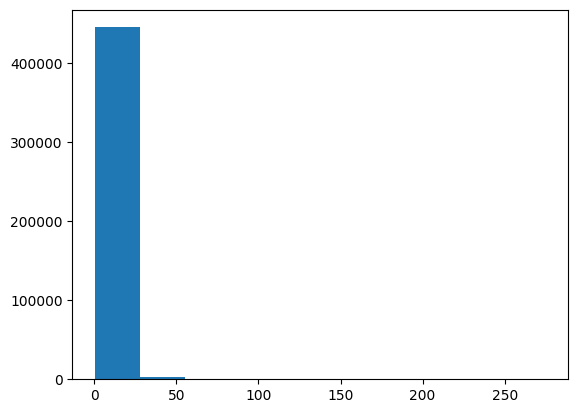

In [15]:
import matplotlib.pyplot as plt
plt.hist(df['PFPI_MINUTES'])

In [10]:
# Create your new scorer to minimize
from sklearn.metrics import make_scorer

from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model_lin = LinearRegression()

cross_val_score(model_lin, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()

-5.169058737719544

In [20]:
model_lin.fit(X_train_scaled, y_train)
model_lin.score(X_test_scaled, y_test)

0.07895794292689717

In [21]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(max_depth=10, n_estimators=200, learning_rate=0.01, n_jobs = -1)
model_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [22]:
cross_val_score(model_xgb, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()

-4.166550220769963

In [23]:
model_xgb.score(X_test_scaled, y_test)

0.4152653801311095

In [25]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor()
model_knn.fit(X_train_scaled, y_train)
cross_val_score(model_knn,  X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()


-5.119858337734533

In [26]:
model_knn.score(X_test_scaled, y_test)

0.11749758206167082

In [29]:
ada = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))
ada.fit(X_train_scaled, y_train)

cross_val_score(ada, X_train_scaled, y_train, cv=10, scoring='neg_root_mean_squared_error').mean()


-4.174673160410659

In [30]:
ada.score(X_test_scaled, y_test)

0.4096742833929563